After some basic EDA of our dataset, but before moving to model training, we should consider trying to cluster out meters into groups. There are 2 reasons for it:

1) Get additiona information on the structure of the dataset, what are the natural groups?

2) Use clustering labels as features for model training, or maybe compartmentize the model by cluster (one model per cluster)

It is not a trivial task to perform efficient clustering on set of time series of big (>10k) length. Usuall techniques include:

1) DTW distance - special way of measuring similarity between timeseries by measuring how expensive it is to deform one into the other

2) SBD, cross-correlation based distance

3) PCA, actually not preferable for time series, doesn't account well for phase shifts, lags etc

It is also possible to use CNN autoencoder to compress the sequence befor feeding it to k-means or some other clustering algorithm, no guarantee that features are meaningful though, + slow. Other methods include wavelet / fourier features, but our data is very non-stationary so I decided against it.

The main issue here is computational complexity of this methods, for instance, DTW has complexity O(n^2) in it's vanilla implementation and can't be used for our case in this form. So some constraints like Sakoe-Chiba (basically limiting the amount of warping) must be used. Another issue is that our data has lots of noise and off-shoots that makes it too hard to get meaningful clustering. For that reason I've decided to use STL denoising + scaling first, and only cluster the resulting processed sequences.

For the clustering method I stick to DTW and SBD + k-means, all implemented in tslearn lib.

In [ ]:
!pip install tslearn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
from joblib import Parallel, delayed
import tslearn.clustering as clust
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
from matplotlib.lines import Line2D

#Method 1. Cluster based on energy consumption shapes
##1.1 KShapes based method

Lets begin with KShapes clustering, it runs faster, allows us to iterate trough differenr n_clusters and see which is better with simple elbow methdo. Then we can target the chosen n_clusters with other clustering method, like DTW based method. For now we'll run clustering on a subsequence, as the full time series clustering will crash our system.

KShapes is a nice method for clustering time series. It clusters sequences based on max correlation similarity, giving focus on the shape. Before feeding it our data, we of course need to normalize it's first 2 moments. Though this method might not be as flexible as DTW based methods, it still might work just well and is a good starting point as it runs faster and cheaper to iterate through. We still have to consider a shork sub sequence to cluster. Though it looks like it will result in poor clustering, we still:

1) get important information of how good this method would perform if applied to the full ssequence.

2) see how "clusterable" our data is in general

3) can quickly iterate through adjustments before using computationally heavy methods like DTW

In [ ]:
df = pd.read_csv("deNaNed_energy.csv")
df["Time"] = pd.to_datetime(df["Time"])
df = df.set_index("Time")

start_date = np.datetime64("2022-09-01")
end_date =  np.datetime64("2022-09-14")
time_mask = (df.index >= start_date) & (df.index <= end_date)

df = df[time_mask]

First, of course, we analyze elbow plot (if there is elbow...) to get some idea about what number of clusters would work better. The problem is that this method of deciding on the number of clusters might fail easily if there is no clear inflection point!

Testing 2 clusters...
0.402 --> 0.370 --> 0.359 --> 0.355 --> 0.353 --> 0.352 --> 0.352 --> 0.352 --> 0.352 --> 
Testing 3 clusters...
0.376 --> 0.342 --> 0.333 --> 0.328 --> 0.328 --> 0.328 --> 0.326 --> 0.325 --> 0.325 --> 
Testing 4 clusters...
0.371 --> 0.322 --> 0.314 --> 0.309 --> 0.307 --> 0.307 --> 
Testing 5 clusters...
0.347 --> 0.302 --> 0.294 --> 0.292 --> 0.290 --> 0.290 --> 0.290 --> 
Testing 6 clusters...
0.333 --> 0.288 --> 0.280 --> 0.277 --> 0.274 --> 0.274 --> 0.274 --> 
Testing 7 clusters...
0.316 --> 0.279 --> 0.271 --> 0.269 --> 0.268 --> 0.267 --> 0.267 --> 
Testing 8 clusters...
0.306 --> 0.269 --> 0.264 --> 0.261 --> 0.260 --> 0.260 --> 
Testing 9 clusters...
0.291 --> 0.261 --> 0.255 --> 0.252 --> 0.252 --> 
Testing 10 clusters...
0.282 --> 0.257 --> 0.252 --> 0.249 --> 0.248 --> 0.248 --> 
Testing 11 clusters...
0.275 --> 0.252 --> 0.247 --> 0.243 --> 0.243 --> 0.243 --> 


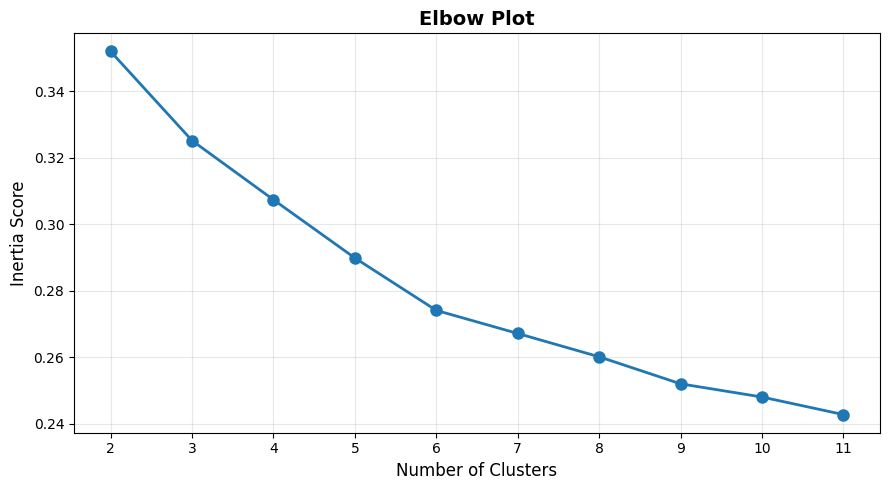

In [ ]:
inert = []
min_clusters = 2
max_clusters_to_test = 12

scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(df.to_numpy().T)

for n_clust in range(min_clusters, max_clusters_to_test):
    print(f"Testing {n_clust} clusters...")
    kshape_test = KShape(n_clusters=n_clust, verbose=True, n_init=1, random_state=42)
    kshape_test.fit_predict(X_scaled)
    inert.append(kshape_test.inertia_)

plt.figure(figsize=(9, 5))
plt.plot(range(min_clusters, max_clusters_to_test), inert, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.title("Elbow Plot", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia Score", fontsize=12)
plt.xticks(range(min_clusters, max_clusters_to_test))
plt.tight_layout()
plt.show()

From the resulting plot above it is hard to decide what is the optimal number of clusters might be. Maybe something around 6-9 might be good. It might be that our data is naturally not well clusterable as we have a limited number if points (120 after preprocessing). We stick to 8 for now

0.306 --> 0.269 --> 0.264 --> 0.261 --> 0.260 --> 0.260 --> 


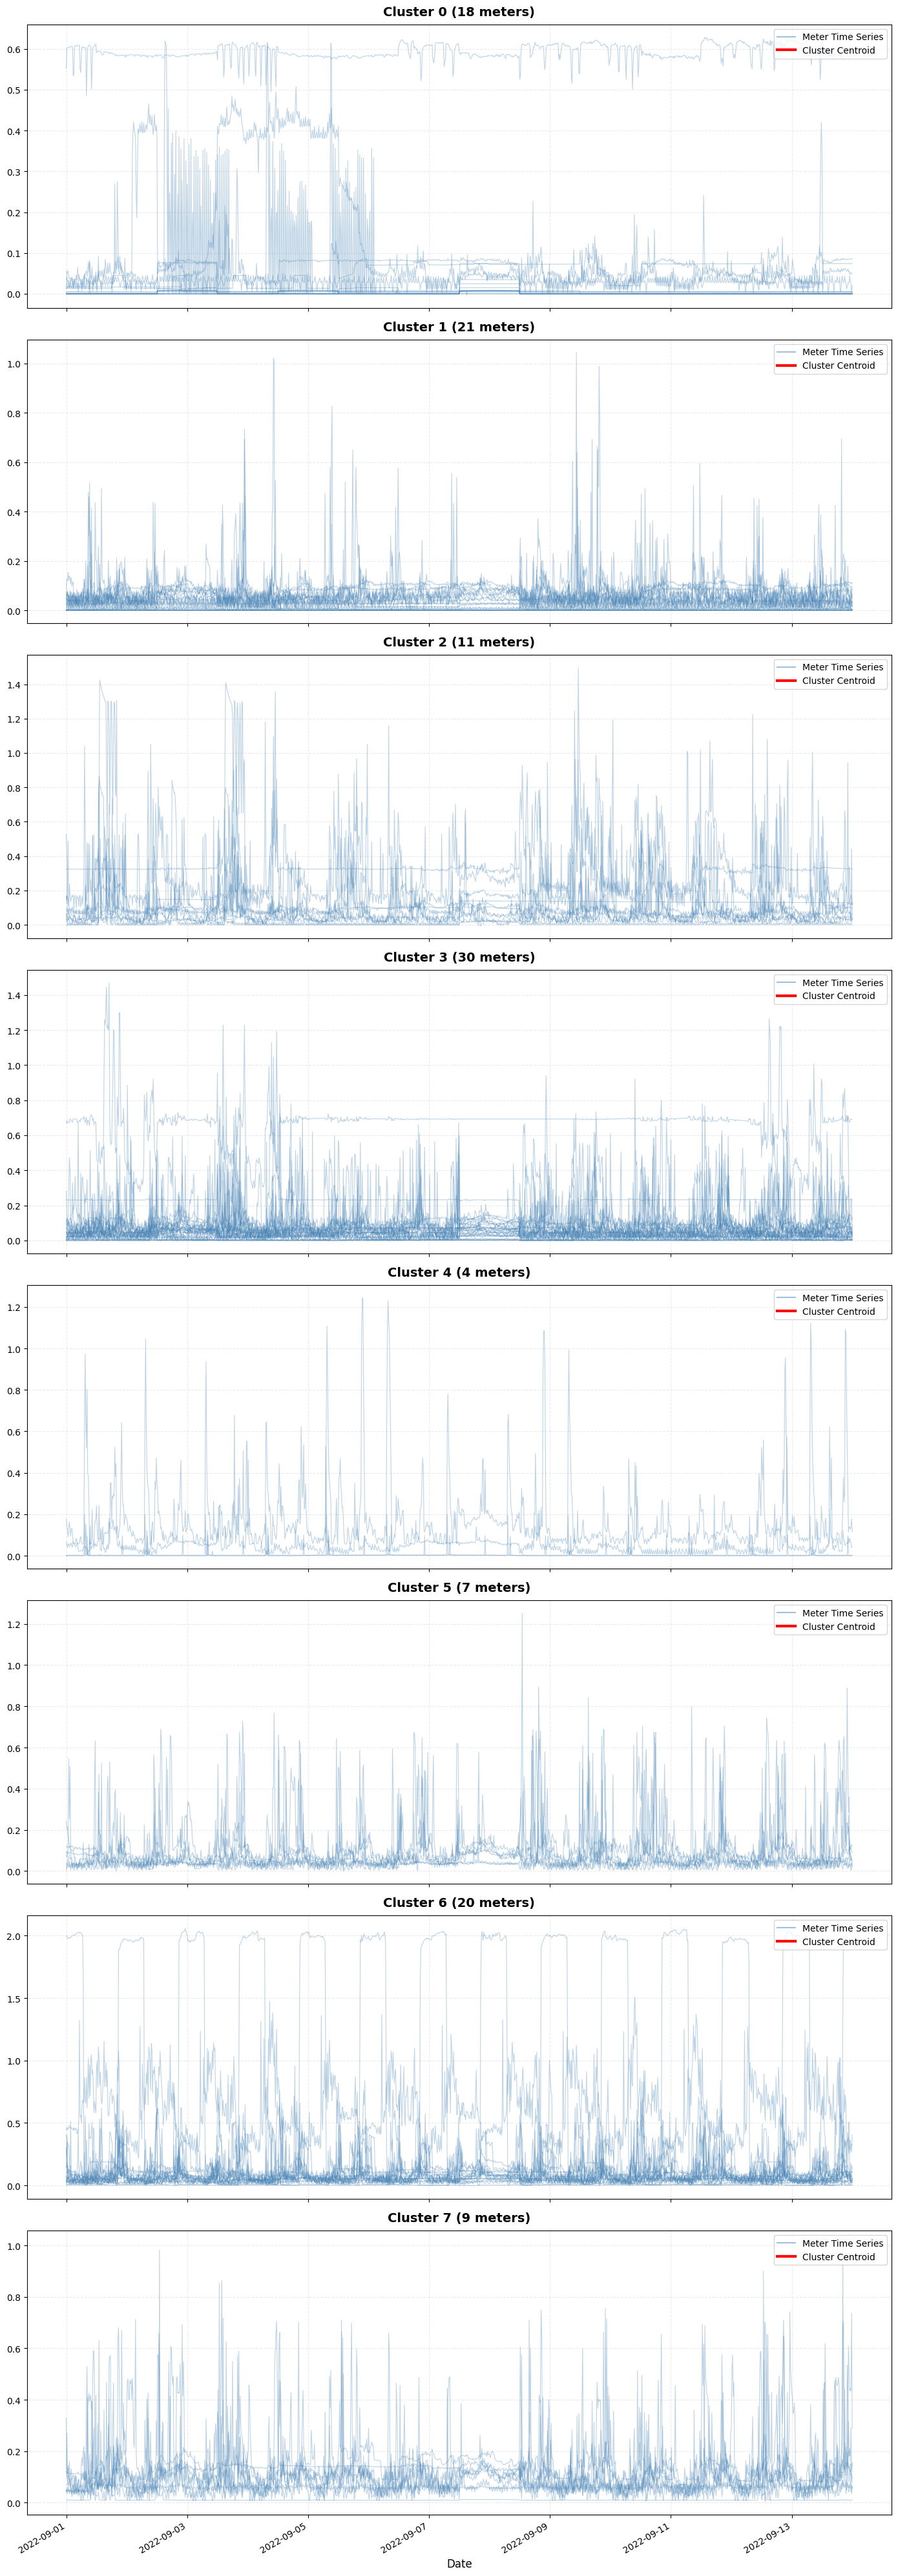

In [ ]:
n_clusters = 8

kshape = KShape(n_clusters=n_clusters, verbose=True, n_init=1, random_state=42)
labels = kshape.fit_predict(X_scaled)
centroids = kshape.cluster_centers_
centroids_original = scaler.fit_transform(centroids)

fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 5 * n_clusters))

for id, ax in enumerate(axes):
    meter_indices = np.where(labels == id)[0]

    for idx in meter_indices:
        ax.plot(df.index, df.iloc[:, idx],
                alpha=0.35, linewidth=0.8, color='steelblue',
                label='_nolegend_')

    ax.set_title(f'Cluster {id} ({len(meter_indices)} meters)',
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.grid(True, alpha=0.25, linestyle='--')

    custom_lines = [Line2D([0], [0], color='steelblue', alpha=0.5, linewidth=1.5)]
    ax.legend(custom_lines, ['Meter Time Series'],
              loc='upper right', fontsize=10)

# Format dates nicely
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

from plots above we that even though we could convince ourselves that some of the clusters make sense (especially clusters 4-7), others are clearly very noise and include a lot of very different sequences. 2 things can be done:

1) increase the number of clusters. But 8 clusters is already a lot for our 120 points dataset, though it is very possible that the natural number of clusters is indeed higher

2) try somethig else

Let's try something else!

#Method 1. Cluster based on energy consumption shapes
##1.1 Denoise then cluster

Let's take a different approach: we first denoise and detrend our data using STL, and only then cluster. This will help the algorithm to not get destracted by random fluctuation in te data and see more of the structure

In [ ]:
seasonal_df = stl_season(df)

100%|██████████| 120/120 [01:24<00:00,  1.42it/s]


Below we see that the overall inercia values got lower, that might a sign that we are moving in the right direction

Testing 2 clusters...
0.296 --> 0.282 --> 0.280 --> 0.278 --> 0.277 --> 0.276 --> 0.275 --> 0.274 --> 0.274 --> 0.274 --> 0.274 --> 0.274 --> 
Testing 3 clusters...
0.272 --> 0.259 --> 0.255 --> 0.252 --> 0.250 --> 0.249 --> 0.249 --> 0.249 --> 
Testing 4 clusters...
0.247 --> 0.226 --> 0.219 --> 0.217 --> 0.216 --> 0.216 --> 0.216 --> 0.216 --> 
Testing 5 clusters...
0.239 --> 0.218 --> 0.208 --> 0.205 --> 0.203 --> 0.203 --> 0.202 --> 0.202 --> 0.202 --> 0.202 --> 0.201 --> 0.201 --> 
Testing 6 clusters...
0.225 --> 0.206 --> 0.197 --> 0.193 --> 0.191 --> 0.190 --> 0.190 --> 0.189 --> 0.189 --> 
Testing 7 clusters...
0.210 --> 0.192 --> 0.189 --> 0.187 --> 0.186 --> 0.186 --> 0.185 --> 0.185 --> 
Testing 8 clusters...
0.199 --> 0.180 --> 0.175 --> 0.174 --> 0.174 --> 
Testing 9 clusters...
0.188 --> 0.168 --> 0.163 --> 0.162 --> 0.162 --> 
Testing 10 clusters...
0.186 --> 0.165 --> 0.159 --> 0.159 --> 
Testing 11 clusters...
0.177 --> 0.158 --> 0.155 --> 0.152 --> 0.149 --> 0.149 -->

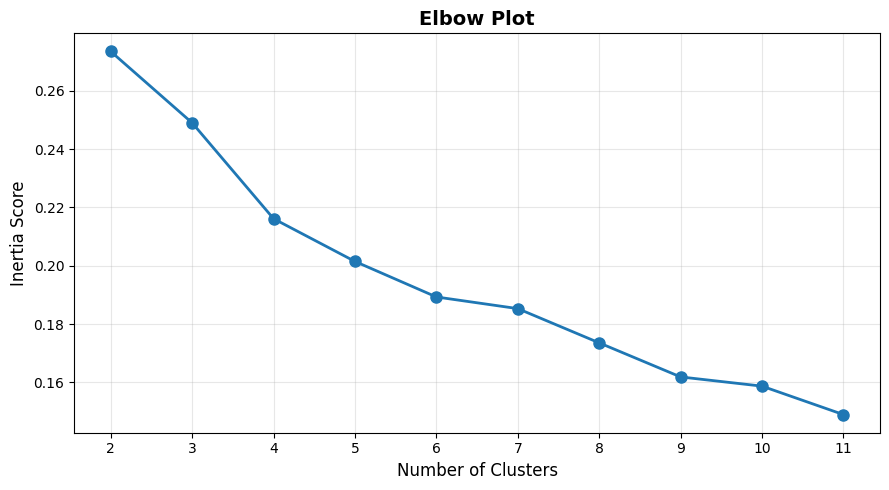

In [ ]:
inert = []
min_clusters = 2
max_clusters_to_test = 12

scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(denoised_df.to_numpy().T)

for n_clust in range(min_clusters, max_clusters_to_test):
    print(f"Testing {n_clust} clusters...")
    kshape_test = KShape(n_clusters=n_clust, verbose=True, n_init=1, random_state=42)
    kshape_test.fit_predict(X_scaled)
    inert.append(kshape_test.inertia_)

plt.figure(figsize=(9, 5))
plt.plot(range(min_clusters, max_clusters_to_test), inert, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.title("Elbow Plot", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia Score", fontsize=12)
plt.xticks(range(min_clusters, max_clusters_to_test))
plt.tight_layout()
plt.show()

0.188 --> 0.168 --> 0.163 --> 0.162 --> 0.162 --> 


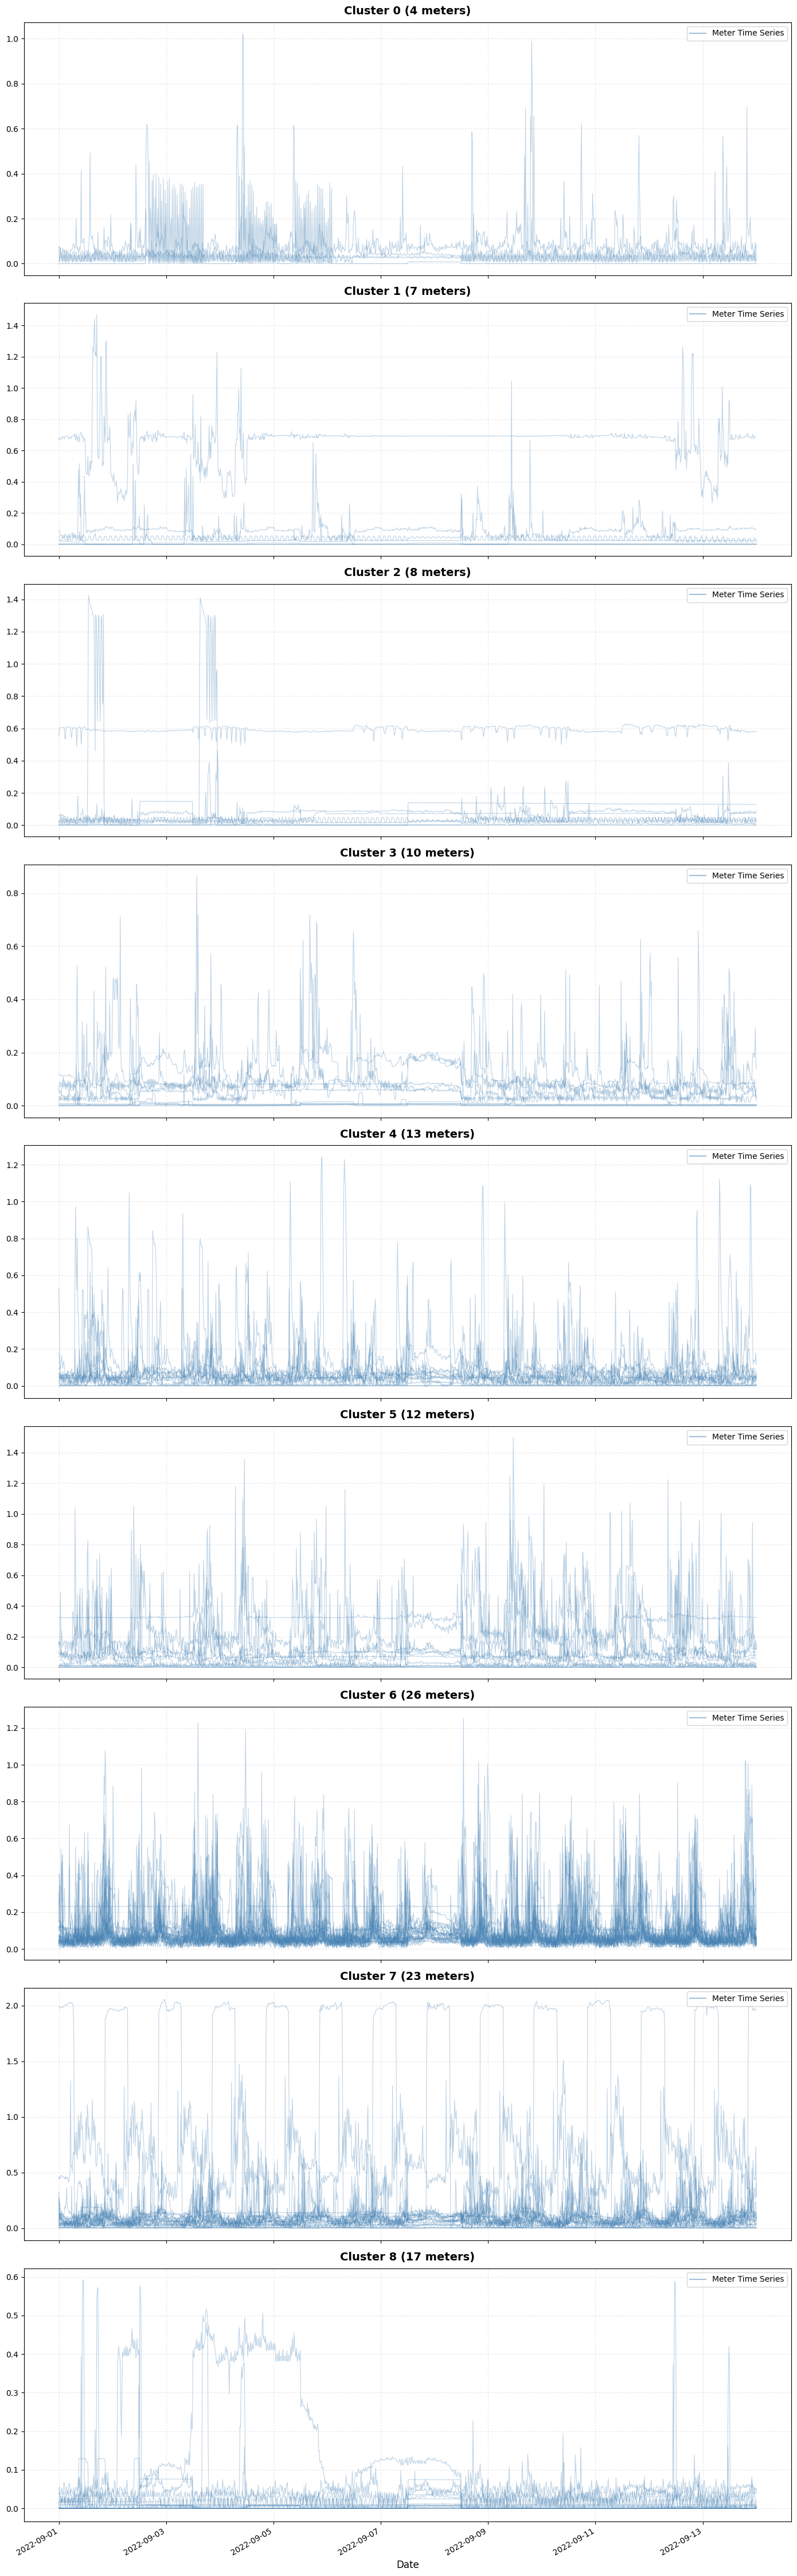

In [ ]:
n_clusters = 9

kshape = KShape(n_clusters=n_clusters, verbose=True, n_init=1, random_state=42)
labels_kshapes = kshape.fit_predict(X_scaled)

fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 5 * n_clusters))

for id, ax in enumerate(axes):
    meter_indices = np.where(labels_kshapes == id)[0]

    for idx in meter_indices:
        ax.plot(df.index, df.iloc[:, idx],
                alpha=0.35, linewidth=0.8, color='steelblue',
                label='_nolegend_')

    ax.set_title(f'Cluster {id} ({len(meter_indices)} meters)',
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.grid(True, alpha=0.25, linestyle='--')

    custom_lines = [Line2D([0], [0], color='steelblue', alpha=0.5, linewidth=1.5)]
    ax.legend(custom_lines, ['Meter Time Series'],
              loc='upper right', fontsize=10)

# Format dates nicely
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

We can see there is some improvement, visually clusters make more sense now, elbow plit has a more defined inflection

#Method 1. Cluster based on energy consumption shapes
##1.1 Denoise then DTW

Let's do another thing: denoise and then apply DTW based clustering. This time no elbow plots to save some time. We'll just set n_clusters to 8

In [ ]:
denoised_df = stl_denoise(df)

100%|██████████| 120/120 [01:19<00:00,  1.52it/s]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  

468.535 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    7.8s finished


303.897 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    8.6s finished


298.972 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    7.4s finished


296.883 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    7.9s finished


296.883 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    8.6s finished


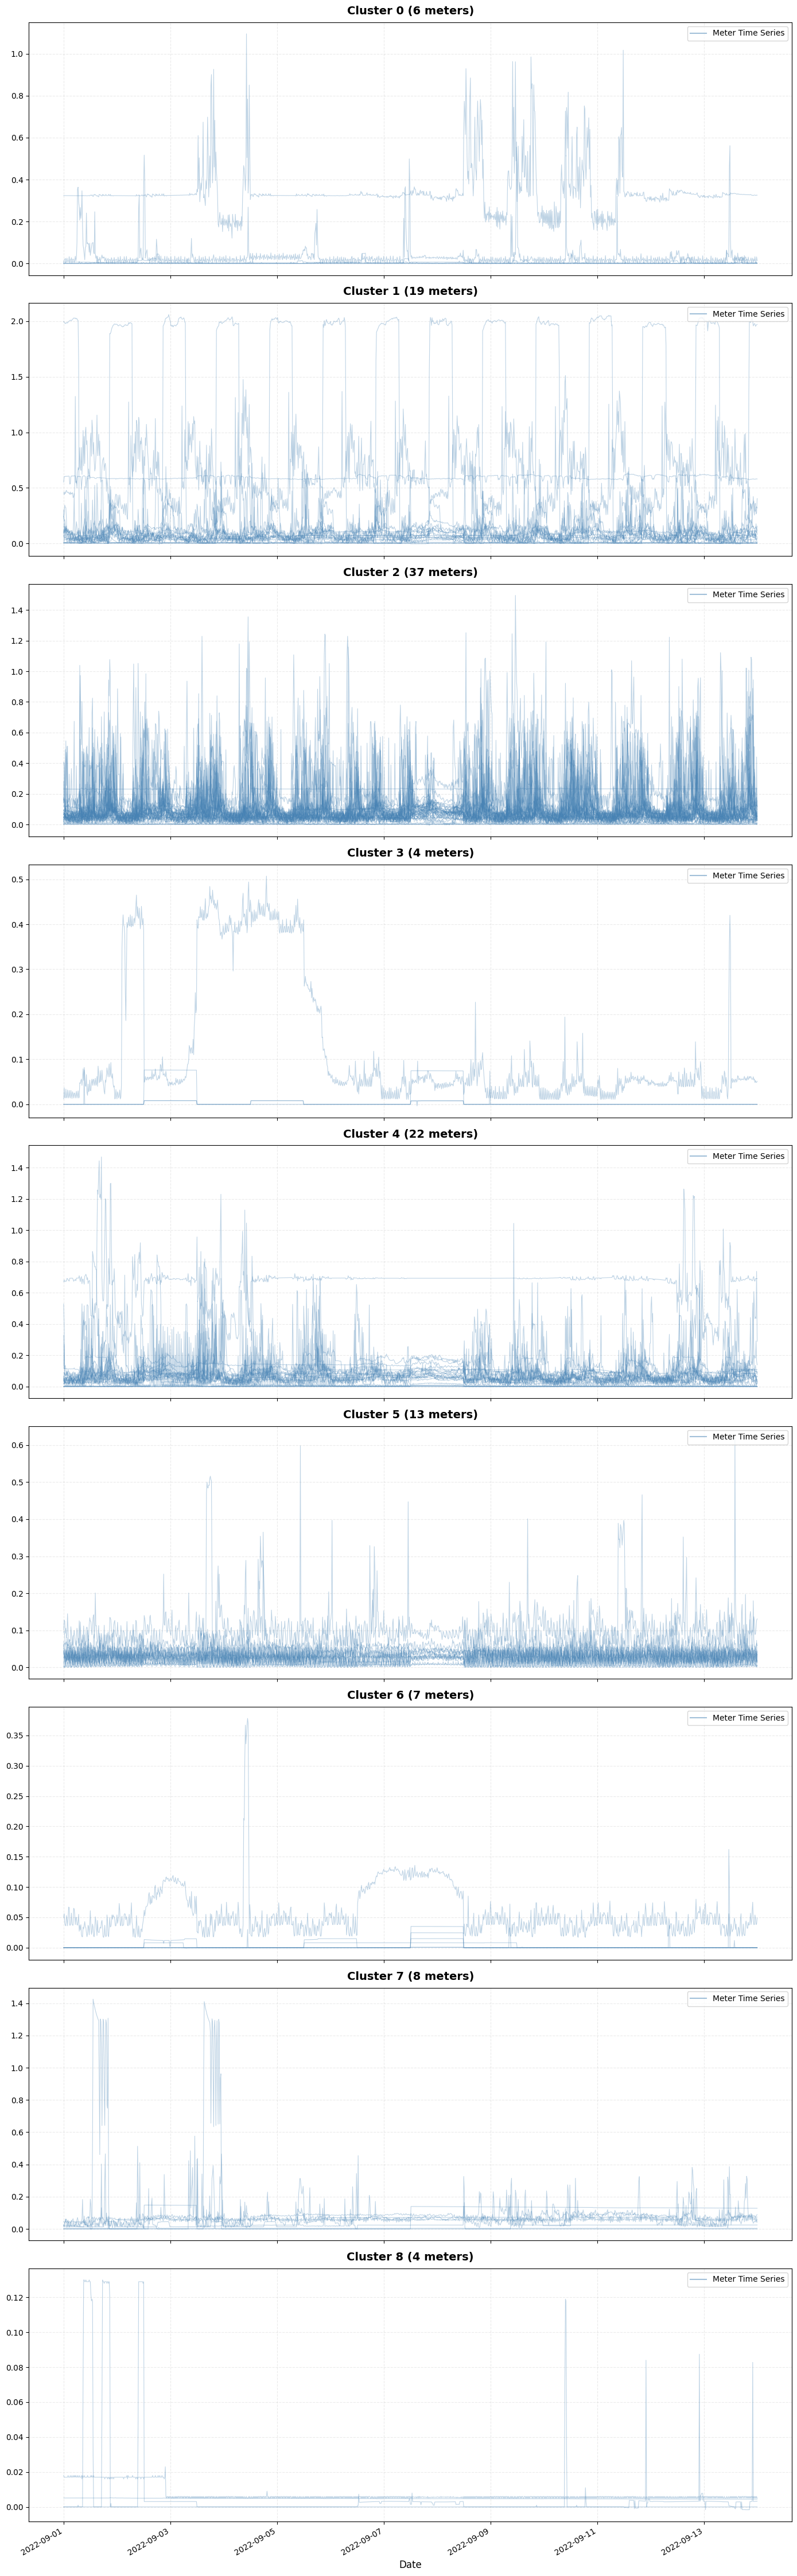

In [ ]:
n_clusters = 9

scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(denoised_df.to_numpy().T)

kshape = clust.TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    metric_params={
        "global_constraint": "sakoe_chiba",
        "sakoe_chiba_radius": 200
    },
    n_jobs=-1,
    verbose=True
)
labels_dtw = kshape.fit_predict(X_scaled)

fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 5 * n_clusters))

for id, ax in enumerate(axes):
    meter_indices = np.where(labels_dtw == id)[0]

    for idx in meter_indices:
        ax.plot(df.index, df.iloc[:, idx],
                alpha=0.35, linewidth=0.8, color='steelblue',
                label='_nolegend_')

    ax.set_title(f'Cluster {id} ({len(meter_indices)} meters)',
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Date', fontsize=12)
    ax.grid(True, alpha=0.25, linestyle='--')

    custom_lines = [Line2D([0], [0], color='steelblue', alpha=0.5, linewidth=1.5)]
    ax.legend(custom_lines, ['Meter Time Series'],
              loc='upper right', fontsize=10)

# Format dates nicely
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Not perfect. It's hard to decide which of the 2 methods is better: KShapes or DTW? One thing is clear though - KShapes with denoising performed ok (though, what is ok???), and it is much faster the DTW ! Visually, KShapes clusters seem to be more even and homogenous.

We can also check how much both clustering methods align using ARI (measures the number of pairs that are are similarly clustered over the total number of pairs; adjusted for random clustering) and NMI - normalized mutual info, measures how similar joint distribution is to the product of distributions of rand vars.

And as result below we see that there is no significant correlation... The ARI score is close to zero, suggesting independence

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_kshapes, labels_dtw)
print(f"Adjusted Rand Index: {ari:.4f}")

nmi = normalized_mutual_info_score(labels_kshapes, labels_dtw)
print(f"Normalized Mutual Information: {nmi:.4f}")

Adjusted Rand Index: 0.1187
Normalized Mutual Information: 0.4041


Concluding this subsection, we can tell that there is some meaning in formed clusters, but the quality is still insufficient. Some clusters seem to be more homogenous. We can use this and target such clusters first during training, for example we can train one model on such nice cluster. Or we can use the clustering labels as features in hope that they convey some useful information...  

ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

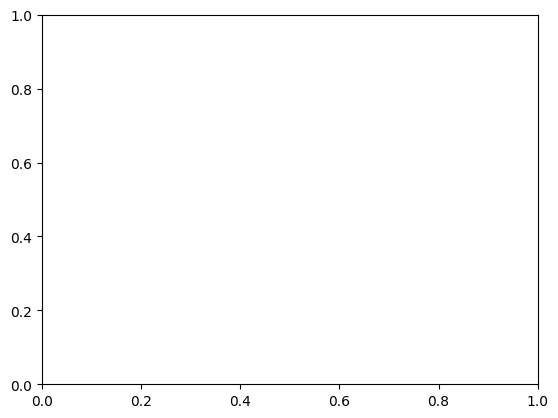

In [ ]:
plt.plot(np.array(range(max_clusters-1))+2, inert)
plt.grid()
plt.title("Elbow plot")
plt.xlabel("Number of cluster")
plt.ylabel("Inertia score")
plt.legend()
plt.show()

Now let's visually inspect the resulting clusters, see if they make sense

In [ ]:
# Data must be z-normalized first!
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(np.log1p(df.to_numpy()).T)

kshape = clust.TimeSeriesKMeans(
    n_clusters=10,
    metric="dtw",
    metric_params={
        "global_constraint": "sakoe_chiba",
        "sakoe_chiba_radius": 200
    },
    n_jobs=-1,
    verbose=True
)


# kshape = clust.KShape(
#     n_clusters=10,
#     verbose=True)

labels = kshape.fit_predict(X_scaled)

# inert.append(kshape.inertia_)

# inert = []

# for i in range(10):
#     print(f"start {i+2} clusters")
#     kshape = clust.KShape(
#         n_clusters=i+2,
#         verbose=True)

#     labels = kshape.fit_predict(X_scaled)

#     inert.append(kshape.inertia_)

# plt.plot(inert)
# plt.show()

# labels = kshape.fit_predict(X_scaled)
# centroids = kshape.cluster_centers_  # Shape: (5, 30000, 1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  

406.941 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    9.4s finished


269.647 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    8.5s finished


267.914 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    8.7s finished


267.914 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   10.2s finished


In [ ]:
kshape.inertia_

np.float64(612.7184649549575)

#Method 2. Weather features clustering

Now we consider clustering based not on shape of energy plots themselves, but rather correlation of energy consumption with weather variables like tempreture.

In [ ]:
energy_file_name = "loureiro_energy.csv"

nan_energy_df = pd.read_csv("deNaNed_energy.csv")
nan_energy_df["Time"] = pd.to_datetime(nan_energy_df["Time"])
nan_energy_df = nan_energy_df.set_index("Time")

weather_file_name = "weather_aveiro_final.csv"

energy_df = pd.read_csv(energy_file_name)
energy_df["Time"] = pd.to_datetime(energy_df["Time"])
energy_df = energy_df.set_index("Time")
weather_df = pd.read_csv(weather_file_name).set_index("Time")
weather_df.index = pd.to_datetime(weather_df.index)

Now we align energy_df and weather_df in time. Remember that energy_df here is preprocessed, so it is shorter the weather_df. Later though we might not want to do this, for example if we want to use lags of weather data. In that case we would need to take the lags first and crop teh sequence after.

In [ ]:
weather_df = weather_df.reindex(index=energy_df.index)
print(f"Weather and Energy dataframes time index match = {(weather_df.index == energy_df.index).all()}")

Weather and Energy dataframes time index match = True


Let's confirm visually that time interval is correct

<Axes: xlabel='Time'>

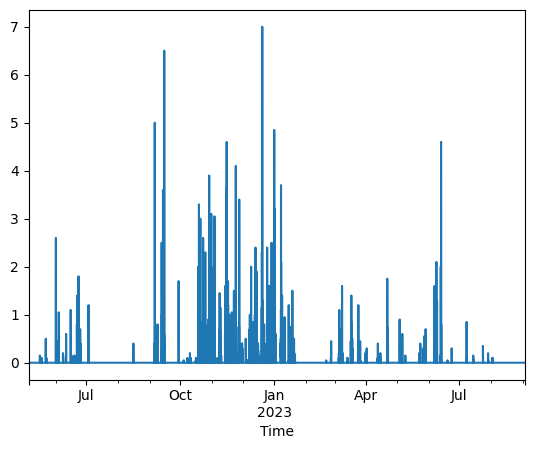

In [ ]:
weather_df['Quantity_Precip'].plot()

In [ ]:
df_combined = nan_energy_df.merge(weather_df, on="Time")
n_col = len(nan_energy_df.columns)

In [ ]:
scale = StandardScaler()
corr_matrix = pd.DataFrame(scale.fit_transform(df_combined), columns = df_combined.columns, index = df_combined.index).corr()
corr_subset = corr_matrix.iloc[:n_col, n_col:]

Let's take a look again at correlation heatmaps, but now with processed energy data. We see that the pattern makes more sense: for instance, correlation between tempreture and energy consumption appears to be much stronger. This is due to the fact that cleaning up bad data in energy_df help track actual correlations

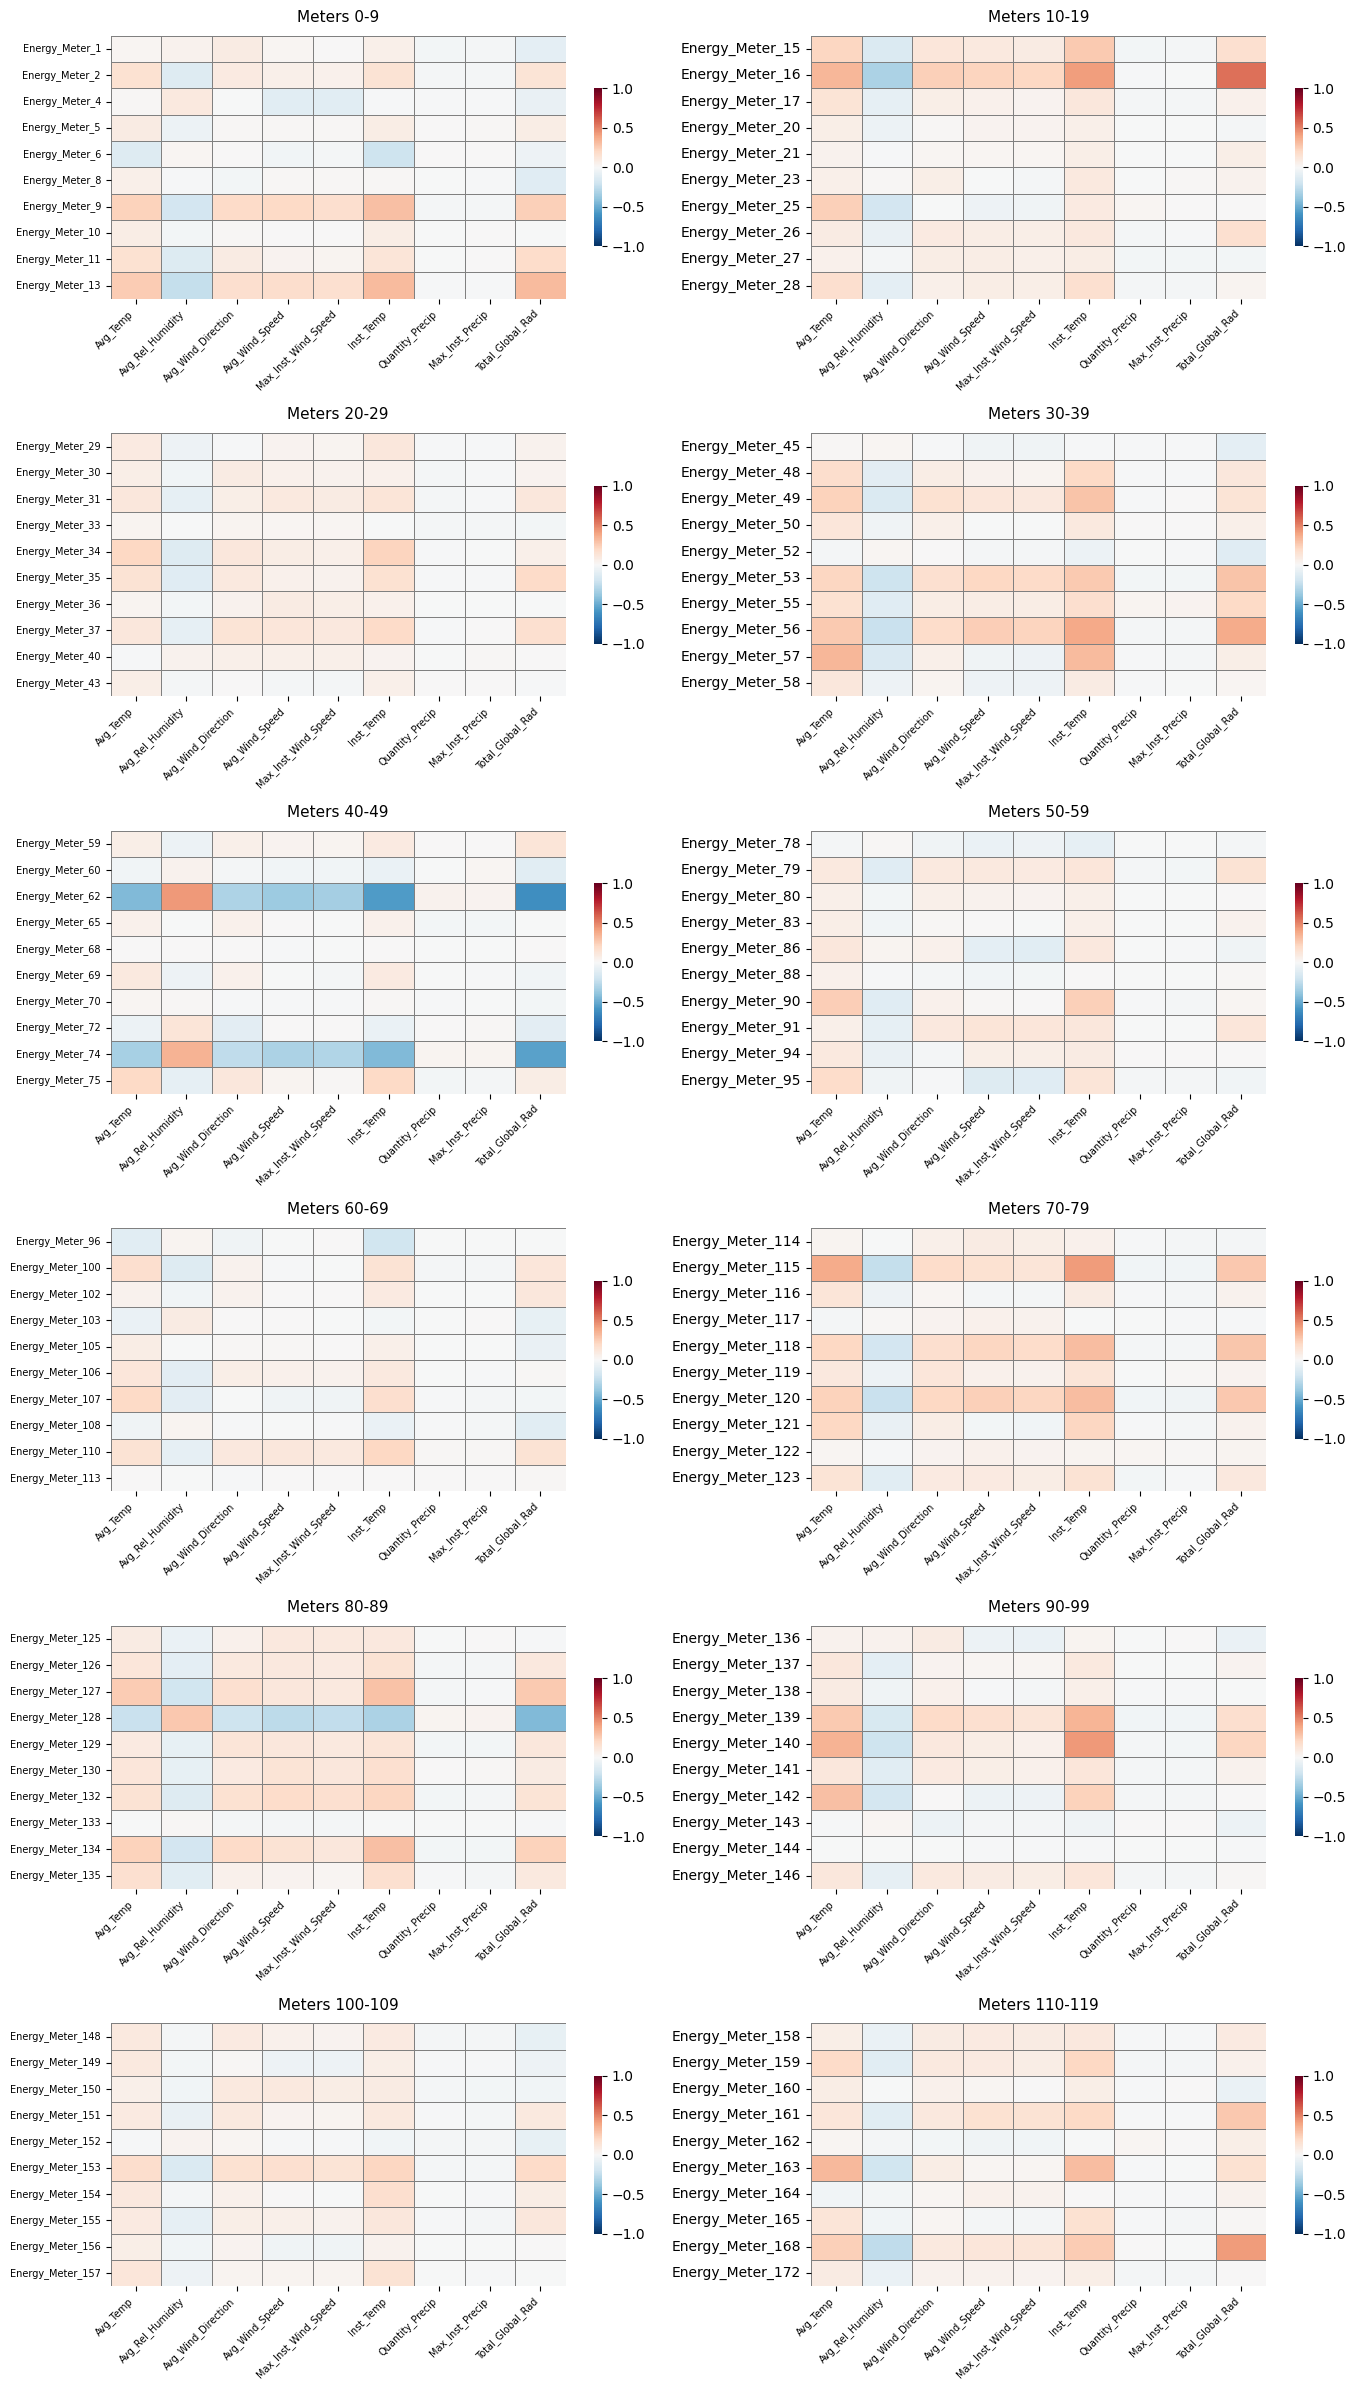

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

chunk_size = 10
n_meters = corr_subset.shape[0]
row_ranges = [(i, min(i + chunk_size, n_meters)) for i in range(0, n_meters, chunk_size)]

n_chunks = len(row_ranges)
n_cols = 2
n_rows = (n_chunks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, (start, end) in enumerate(row_ranges):
    ax = axes[idx]

    corr_chunk = corr_subset.iloc[start:end, :]

    sns.heatmap(
        corr_chunk,
        ax=ax,
        cmap='RdBu_r',
        center=0,
        vmin=-1,
        vmax=1,
        cbar=True,
        cbar_kws={'shrink': 0.6},
        linewidths=0.5,
        linecolor='gray'
    )

    ax.set_title(f'Meters {start}-{end-1}', fontsize=11, pad=10)

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)

    if idx % n_cols == 0:
        plt.setp(ax.get_yticklabels(), fontsize=7)
    else:
        ax.set_ylabel('')

for idx in range(n_chunks, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

In [ ]:
X_cosine = normalize(corr_subset)


In [ ]:
kmeans_cosine = KMeans(
    n_clusters=12,
    n_init=10,
    random_state=42
)
cosine_labels = kmeans_cosine.fit_predict(X_cosine)

# Check cluster centroids (also unit vectors)
centroids_cosine = kmeans_cosine.cluster_centers_

Testing k values: 100%|██████████| 18/18 [00:00<00:00, 32.64it/s]
/tmp/ipython-input-2417208113.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


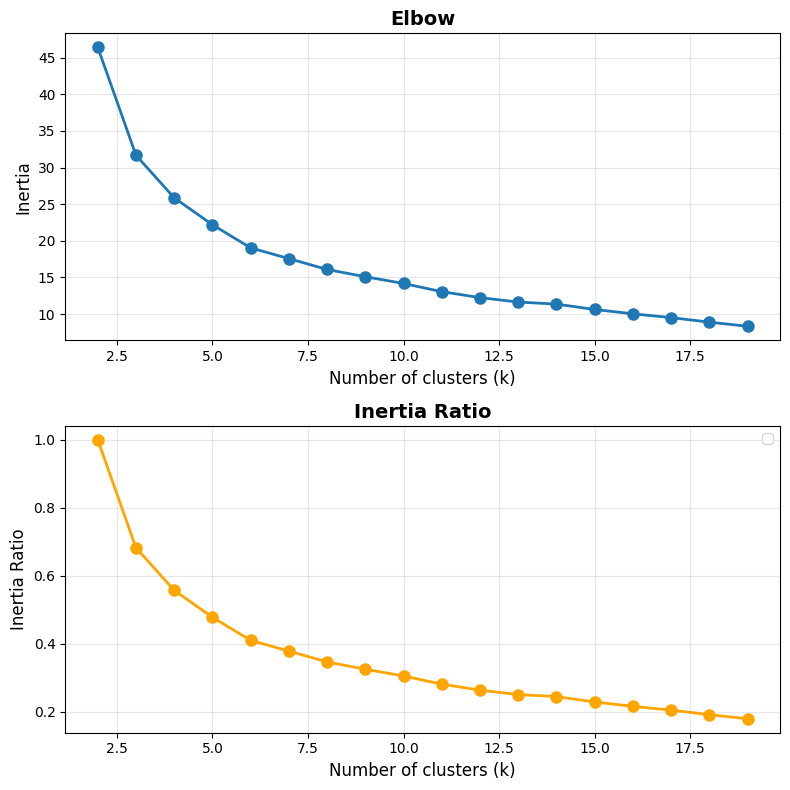

In [ ]:
from sklearn.metrics import silhouette_score

inertia_values = []
K_range = range(2, 20)
silhouette_scores = []

for k in tqdm(K_range, desc="Testing k values"):
    kmeans = KMeans(
        n_clusters=k,
        n_init=10,
        random_state=42,
        max_iter=300
    )
    kmeans.fit(X_cosine)

    inertia_values.append(kmeans.inertia_)

    sil_score = silhouette_score(X_cosine, kmeans.labels_, metric="cosine")
    silhouette_scores.append(sil_score)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(K_range, inertia_values, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

inertia_ratio = np.array(inertia_values) / inertia_values[0]
ax2.plot(K_range, inertia_ratio, 'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Number of clusters (k)', fontsize=12)
ax2.set_ylabel('Inertia Ratio', fontsize=12)
ax2.set_title('Inertia Ratio', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
def stl_season(df, n_jobs=-1):

    def process_single_column(args):
        series = args

        try:
            stl = STL(series, period=96, seasonal=9, robust=True)
            result = stl.fit()

            reconstructed = result.seasonal

            return reconstructed.values
        except Exception as e:
            print(f"STL failed for series: {e}")
            return series

    colomn_names = df.columns

    args = [df[name] for name in colomn_names]

    reconstructed_values = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process_single_column)(arg) for arg in tqdm(args, total=len(colomn_names))
    )

    df = pd.DataFrame(np.column_stack(reconstructed_values), index=df.index, columns=df.columns)

    return df

def stl_detrend(df, n_jobs=-1):

    def process_single_column(args):
        series = args

        try:
            stl = STL(series, period=96, seasonal=9, robust=True)
            result = stl.fit()

            reconstructed = result.seasonal + result.resid

            return reconstructed.values
        except Exception as e:
            print(f"STL failed for series: {e}")
            return series

    colomn_names = df.columns

    args = [df[name] for name in colomn_names]

    reconstructed_values = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process_single_column)(arg) for arg in tqdm(args, total=len(colomn_names))
    )

    df = pd.DataFrame(np.column_stack(reconstructed_values), index=df.index, columns=df.columns)

    return df


def stl_denoise(df, n_jobs=-1):

    def process_single_column(args):
        series = args

        try:
            stl = STL(series, period=96, seasonal=9, robust=True)
            result = stl.fit()

            reconstructed = result.seasonal + result.trend

            return reconstructed.values
        except Exception as e:
            print(f"STL failed for series: {e}")
            return series

    colomn_names = df.columns

    args = [df[name] for name in colomn_names]

    reconstructed_values = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process_single_column)(arg) for arg in tqdm(args, total=len(colomn_names))
    )

    df = pd.DataFrame(np.column_stack(reconstructed_values), index=df.index, columns=df.columns)

    return df